<a href="https://colab.research.google.com/github/haidarizz/CatDogClassification/blob/main/Cat_and_Dog_Classification_Deep_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project Kecerdasan Buatan Deep Learning
## Cat and Dog Classification 
Kelompok Budak Raden
* Muhammad Haidar I. 20/460554/TK/51143
* Rizky Intan Nurlita 		20/456379/TK/50509
* Raden Muhammad Banendra	20/460560/TK/51149
* Laili Rofi’ah 			 20/463604/TK/51596

## Load The Dataset
Kami menggunakan dataset yang disediakan oleh Kaggle. Dataset dapat diakses pada link berikut:
https://www.kaggle.com/competitions/dogs-vs-cats-redux-kernels-edition/data 

Data tersebut kami masukkan pada google drive, untuk selanjutnya dapat diakses langsung dengan *mount*.
Data tersebut dapat dilihat pula pada link drive berikut:
https://drive.google.com/drive/folders/1LUyn12GF_y3MKjW0Vtth2dTEKgF-sht6?usp=sharing


In [ ]:
from google.colab import drive
drive.mount('/content/drive/')
TRAIN_DIR = 'drive/MyDrive/PetImages2/train'
TEST_DIR = 'drive/MyDrive/PetImages2/test'

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


## Import Modules
Memasukkan modul yang akan digunakan dalam keseluruhan proses classification.

In [ ]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import random
import tensorflow as tf
warnings.filterwarnings('ignore')
%matplotlib inline

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import load_img
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D
from google.colab import files
from tqdm.notebook import tqdm
from PIL import Image

# Create DataFrame
Membuat list yang berisikan label pada setiap gambar. Label 0 untuk gambar cat dan label 1 untuk gambar dog.

Membuat list yang berisikan path letak gambar disimpan, gunanya untuk mengakses gambar tersebut secara langsung.

In [ ]:
# fungsi untuk membuat array yang berisikan label dan path
def load_dataset(directory):
  image_paths = []
  labels = []

  for filename in os.listdir(directory):
      image_path = os.path.join(directory, filename)
      image_paths.append(image_path)
      if filename.startswith("cat."):
        labels.append(0)
      else:
        labels.append(1)
  return image_paths, labels

Membuat dataframe yang terdiri dari 'images' dan 'label'. Kemudian mengacak urutannya baik dari kolom images maupun kolom label. Pengacakan dilakukan supaya proses training menjadi lebih efektif dan akurat.

In [ ]:
train = pd.DataFrame()  # membuat dataframe untuk train
test = pd.DataFrame()   # membuat dataframe untuk test
train['image'], train['label'] = load_dataset(TRAIN_DIR)
test['image'], test['label'] = load_dataset(TEST_DIR)
train = train.sample(frac=1).reset_index(drop=True) # mengacak urutan data
test

,image,label
0,drive/MyDrive/PetImages2/test/dog.1003.jpg,1
1,drive/MyDrive/PetImages2/test/dog.1004.jpg,1
2,drive/MyDrive/PetImages2/test/dog.1002.jpg,1
3,drive/MyDrive/PetImages2/test/dog.1001.jpg,1
4,drive/MyDrive/PetImages2/test/dog.1005.jpg,1
...,...,...
395,drive/MyDrive/PetImages2/test/cat.1194.jpg,0
396,drive/MyDrive/PetImages2/test/cat.1195.jpg,0
397,drive/MyDrive/PetImages2/test/cat.1200.jpg,0
398,drive/MyDrive/PetImages2/test/cat.1199.jpg,0


## Exploratory Data Analysis
Pada bagian ini, kita melihat segmentasi dari dataset yang kita gunakan.


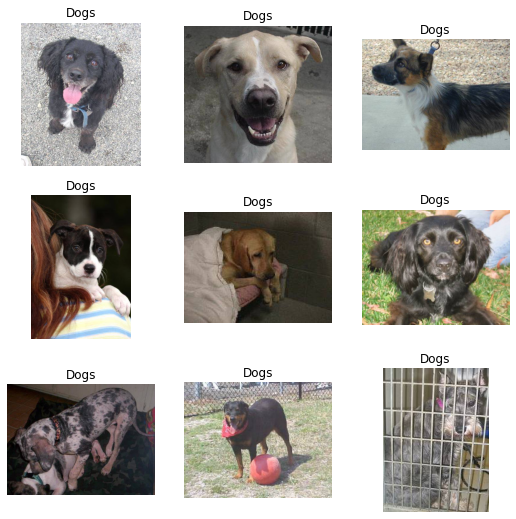

In [ ]:
# untuk menampilkan sampel gambar dog secara acak

# membuat figure dengan ukuran 9x9
plt.figure(figsize=(9,9))

# memfilter hanya untuk gambar dog saja dengan 'label'=1
# mengambil 'image' letak gambar dog disimpan
temp = train[train['label']==1]['image']

# mengambil gambar secara acak disimpan di variabel 'start'
start = random.randint(0, len(temp))

# dari 'start' diambil hanya 9 gambar pertama, disimpan di variabel 'files'
files = temp[start:start+9]

# dari 'files' gambar ditampilkan pada output dengan loop for
for index, file in enumerate(files):
  plt.subplot(3,3, index+1)
  img = load_img(file)
  img = np.array(img)
  plt.imshow(img)
  plt.title('Dogs')
  plt.axis('off')

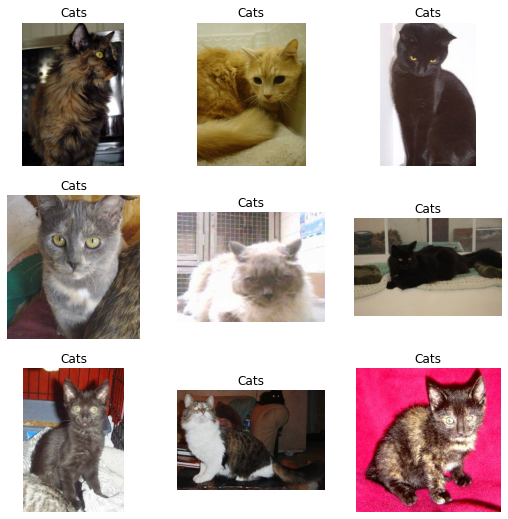

In [ ]:
# untuk menampilkan sampel gambar cat secara acak

# membuat figure dengan ukuran 9x9
plt.figure(figsize=(9,9))

# memfilter hanya untuk gambar cat saja dengan 'label'=0
# mengambil 'image' letak gambar cat  disimpan
temp = train[train['label']==0]['image']

# mengambil gambar secara acak disimpan di variabel 'start'
start = random.randint(0, len(temp))

# dari 'start' diambil hanya 9 gambar pertama, disimpan di variabel 'files'
files = temp[start:start+9]

# dari 'files' gambar ditampilkan pada output dengan loop for
for index, file in enumerate(files):
  plt.subplot(3,3, index+1)
  img = load_img(file)
  img = np.array(img)
  plt.imshow(img)
  plt.title('Cats')
  plt.axis('off')

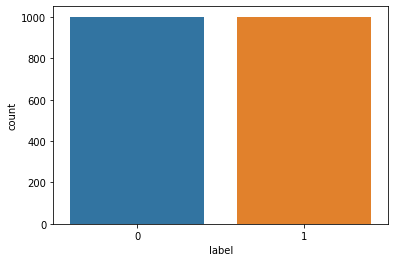

In [ ]:
# melihat jumlah dari dataframe train
import seaborn as sns
sns.countplot(train['label'])

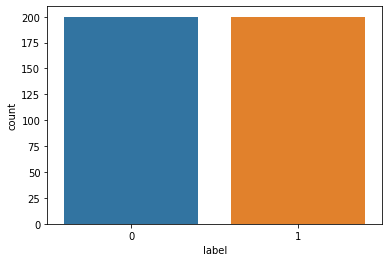

In [ ]:
# melihat jumlah dari dataframe test
import seaborn as sns
sns.countplot(test['label'])

## Feature Extraction
Pada bagian ini, gambar yang akan digunakan untuk proses training akan masuk pada proses Feature Extraction.

In [ ]:
def extract_features(images):
    features = []
    for image in tqdm(images):
        img = load_img(image, grayscale=True)
        img = img.resize((128, 128), Image.ANTIALIAS)
        img = np.array(img)
        features.append(img)
        
    features = np.array(features)
    features1 = features.reshape(len(features), 128, 128, 1)
    return features

In [ ]:
train_features = extract_features(train['image'])

  0%|          | 0/2002 [00:00<?, ?it/s]

In [ ]:
test_features = extract_features(test['image'])

  0%|          | 0/400 [00:00<?, ?it/s]

In [ ]:
## normalisasi gambar menjadi range 0-1
x_train = train_features/255.0
x_test = test_features/255.0

In [ ]:
## mengkonversi label menjadi bentuk integer
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(train['label'])
y_train = le.transform(train['label'])
y_test = le.transform(test['label'])

In [ ]:
# mengubah integer menjadi bentuk binary
y_train = to_categorical(y_train, num_classes=2)
y_test = to_categorical(y_test, num_classes=2)

## Model Creation

In [ ]:
model = Sequential()

input_shape = (128,128,1)
output_class = 2
# convolutional layers
model.add(Conv2D(128, kernel_size=(3,3), activation='relu', input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

model.add(Conv2D(256, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

model.add(Conv2D(512, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

model.add(Conv2D(512, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

model.add(Flatten())

# fully connected layers
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.3))

# output layer
model.add(Dense(output_class, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics='accuracy')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 128)     1280      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 128)      0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 63, 63, 128)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 256)       295168    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 30, 256)      0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 30, 30, 256)       0

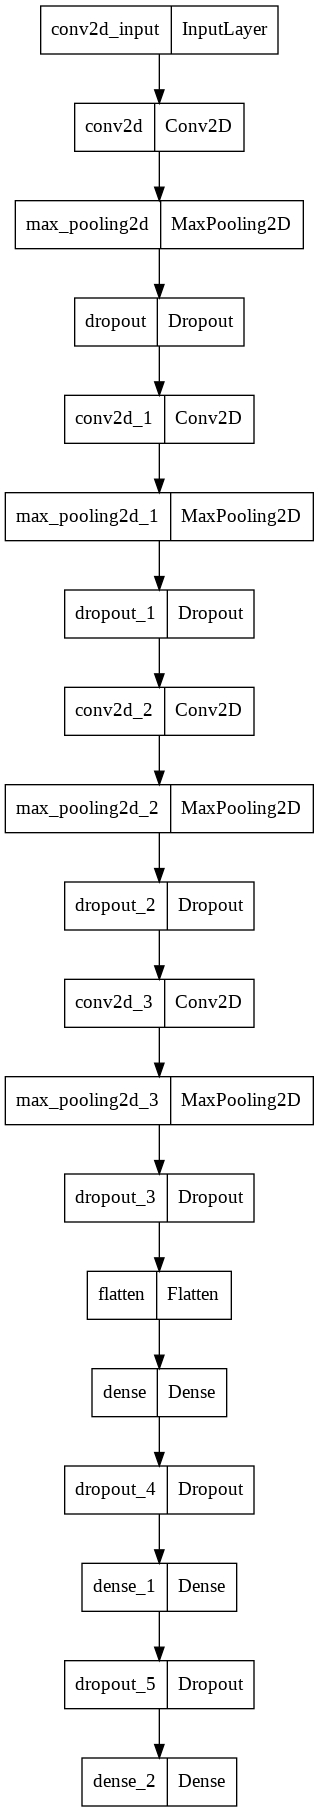

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model)

In [ ]:
# train the model
history = model.fit(x=x_train, y=y_train, batch_size=128, epochs=25, validation_data=(x_test, y_test))

Epoch 1/25
16/16 [==============================] - 5s 342ms/step - loss: 0.5937 - accuracy: 0.6798 - val_loss: 0.6495 - val_accuracy: 0.6275
Epoch 2/25
16/16 [==============================] - 5s 340ms/step - loss: 0.5828 - accuracy: 0.6873 - val_loss: 0.6411 - val_accuracy: 0.6450
Epoch 3/25
16/16 [==============================] - 5s 343ms/step - loss: 0.5644 - accuracy: 0.7023 - val_loss: 0.6541 - val_accuracy: 0.6450
Epoch 4/25
16/16 [==============================] - 5s 343ms/step - loss: 0.5514 - accuracy: 0.7253 - val_loss: 0.6633 - val_accuracy: 0.6250
Epoch 5/25
16/16 [==============================] - 5s 344ms/step - loss: 0.5383 - accuracy: 0.7263 - val_loss: 0.6743 - val_accuracy: 0.6325
Epoch 6/25
16/16 [==============================] - 6s 346ms/step - loss: 0.5119 - accuracy: 0.7448 - val_loss: 0.6194 - val_accuracy: 0.7025
Epoch 7/25
16/16 [==============================] - 6s 345ms/step - loss: 0.5085 - accuracy: 0.7522 - val_loss: 0.6575 - val_accuracy: 0.6300
Epoch 

## Validation and Accuracy Plot
Memplotting untuk melihat perkembangan dari validation dan accuracy hasil training.


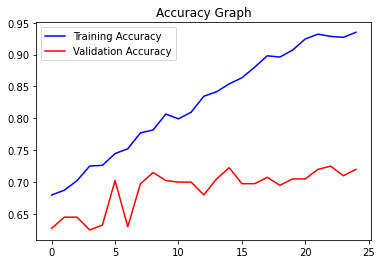

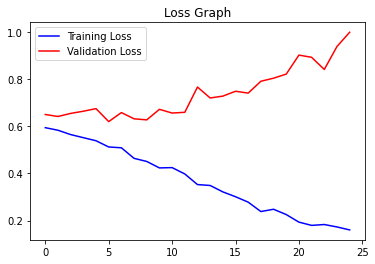

In [ ]:
# menampilkan plot accuracy, baik dari proses training maupun validation
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(len(acc))
plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.figure()

# menampilkan plot loss, baik dari proses training maupun validation
loss = history.history['loss']
val_loss = history.history['val_loss']
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Loss Graph')
plt.legend()
plt.show()

## Image Prediction
Pada bagian ini kita bisa mencoba untuk mendeteksi gambar kucing atau anjing dengan model yang sudah dibuat di atas.

In [ ]:
# fungsi untuk mendeteksi gambar yang inputnya berasal dari dataset test

def pred_from_test():
  use_samples = []
  pred = []
  samples_to_predict = []

  # jumlah sampel yang akan di-input-kan
  n = int(input("Enter number of sample test that you want to predict : "))
  # iterasi sampai jumlah sampel yang akan di-input-kan
  for i in range(0, n):
    use_samples.append(int(input()))
  
  # reshape setiap gambar yang dipredict
  for sample in use_samples:
    reshaped_image = x_test[sample].reshape((128, 128))
    samples_to_predict.append(x_test[sample])
    
    # menampilkan gambar yang ingin dipredict
    plt.imshow(reshaped_image)
    plt.show()

  # mengkonversikan ke numpy array
  samples_to_predict = np.array(samples_to_predict)

  # membuat prediksi untuk setiap sampel
  predictions = model.predict(samples_to_predict)

  # menampilkan arg max untuk hasil prediksi
  classes = np.argmax(predictions, axis = 1)  
  
  print("Gambar di atas berurutan dideteksi adalah: ")
  for i in range(0,n):
    pred.append(animal_dict[int(classes[i])])
    print(pred[i])

In [ ]:
# fungsi untuk mendeteksi gambar yang inputnya berasal dari local file user

def pred_input_image():
  imej = files.upload()
  image_input = (extract_features(imej))/255.
  image_input_reshape = np.squeeze(image_input, axis=(0,))
  k = image_input_reshape
  samples_to_predict = []
  
  # gambar yang telah di-reshape
  reshaped_image = k.reshape((128, 128))

  # menambahkan sampel ke array
  samples_to_predict.append(k)

  # mengkonversikan ke numpy array
  samples_to_predict = np.array(samples_to_predict)

  # memprediksi sampel yang telah dimasukkan
  predictions = model.predict(samples_to_predict)

  # menampilkan arg max untuk hasil prediksi
  classes = np.argmax(predictions, axis = 1)
  pred = animal_dict[int(classes)]

  # menampilkan gambar yang ingin dipredict
  plt.imshow(reshaped_image)
  plt.title(f"Prediction: {pred}")
  plt.show()

Enter 1 for predict an image from your local file or 2 for predict multiple images from our test dataset : 1


Saving doge.jpg to doge (1).jpg


  0%|          | 0/1 [00:00<?, ?it/s]

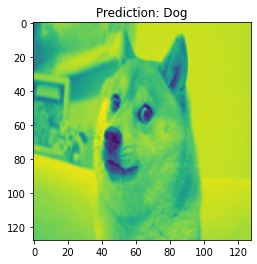

In [ ]:
# run program di bawah ini untuk mencoba mendeteksi gambar

from google.colab import files
animal_dict = ['Cat', 'Dog']
opt = int(input("Enter 1 for predict an image from your local file or 2 for predict multiple images from our test dataset : "))
if opt == 1:
  pred_input_image()
else:
  pred_from_test()